In [3]:
import torch
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, sampler
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.49139969, 0.48215842, 0.44653093], [0.20220212, 0.19931542, 0.20086347])
])
training_data = CIFAR10('cifar/train', train=True, download=True, transform=transform)
test_data = CIFAR10('cifar/test', train=False, download=True, transform=transform)
loader = DataLoader(training_data, 32, sampler=sampler.SubsetRandomSampler(range(49000)))
loader_val = DataLoader(training_data, 32, sampler=sampler.SubsetRandomSampler(range(49000,50000)))
loader_test = DataLoader(test_data, 32)

Files already downloaded and verified
Files already downloaded and verified


In [48]:
#calculate dataset mean and std per channel to feed to transform normalization params
def calc_normalize_values():
    means = np.zeros(3)
    stds = np.zeros(3)
    N = len(training_data)
    for i, (data, label) in enumerate(training_data):
        means += data.numpy().mean(axis=(1,2))
        stds += data.numpy().std(axis=(1,2))
    means /= N
    stds /= N
    print(means, stds)
calc_normalize_values()

KeyboardInterrupt: 

In [5]:
(data, labels) = next(iter(loader))
print(data.shape)

torch.Size([32, 3, 32, 32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


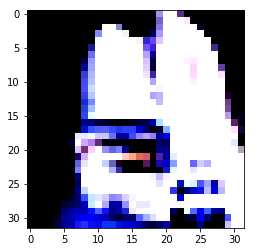

In [6]:
im = data[5].numpy()
plt.imshow(im.T)

In [7]:
if not torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using ' + str(device))

using cpu


In [25]:
p={}
W1 = torch.randn((32, 3, 5, 5), dtype=torch.float32, device=device) * np.sqrt(2. / (3*5*5))
W1.requires_grad = True
b1 = torch.zeros((32,), dtype=torch.float32, requires_grad=True, device=device)
W2 = torch.randn((16, 32, 3, 3), dtype=torch.float32, device=device) * np.sqrt(2. / (32*3*3))
W2.requires_grad = True
b2 = torch.zeros((16,), dtype=torch.float32, requires_grad=True, device=device)
W3 = torch.randn((16*32*32, 10), dtype=torch.float32, device=device) * np.sqrt(2. / (16*32*32))
W3.requires_grad = True
b3 = torch.zeros((10,), dtype=torch.float32, requires_grad=True, device=device)
p=(W1, b1, W2, b2, W3, b3)

In [17]:
def convnet(x, params):
    (W1, b1, W2, b2, W3, b3) = params
    a1 = F.conv2d(x, weight=W1, bias=b1, padding=2)
    z1 = F.relu(a1)
    a2 = F.conv2d(z1, weight=W2, bias=b2, padding=1)
    z2 = F.relu(a2)
    z2 = z2.view(z2.shape[0], -1)
    a3 = z2.mm(W3) + b3
    return a3

#scores = convnet(data, p)
#loss = torch.nn.CrossEntropyLoss()
#cost = loss(scores, labels)
#cost.backward()

In [18]:
len(loader_test.dataset)/32

312.5

In [19]:
def check_accuracy():
    acc = 0
    num_samples = 0
    for i, (data, labels) in enumerate(loader_val):
        scores = convnet(data, p)
        res = scores.argmax(dim=1)
        correct = res == labels
        acc += correct.sum().float()/labels.shape[0]
        num_samples += 1
    acc /= num_samples
    return float(acc)

In [ ]:
for idx, (data, labels) in enumerate(loader):
    data = data.to(device=device, dtype=torch.float32)
    labels = labels.to(device=device, dtype=torch.long)
    scores = convnet(data, p)
    cost = F.cross_entropy(scores, labels)
    cost.backward()
    with torch.no_grad():
        for w in p:
            w -= 3e-3 * w.grad
            w.grad.zero_()
    if idx % 100 == 0:
        print('iteration %d, cost is %f, test accuracy is %f' % (idx, float(cost), check_accuracy()))

iteration 0, cost is 8041.079102, test accuracy is 0.106445
iteration 100, cost is 6.596337, test accuracy is 0.091797
iteration 200, cost is 3.649671, test accuracy is 0.103516
iteration 300, cost is 3.749621, test accuracy is 0.075195
iteration 400, cost is 2.383446, test accuracy is 0.074219
iteration 500, cost is 2.248861, test accuracy is 0.106445
iteration 600, cost is 2.301419, test accuracy is 0.106445


In [285]:
a=(2,3,4)
2./a[1:]

TypeError: unsupported operand type(s) for /: 'float' and 'tuple'